In [31]:
import warnings
warnings.filterwarnings('ignore')
import re
import math
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import chi2
from pylab import barh,plot,yticks,show,grid,xlabel,figure
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# read the data back in
heartDisease = pd.read_pickle("heartDisease.pkl")
X = heartDisease
X = np.array(X)

In [33]:
#original
print("Positive class (Presence of): {}".format((X[:,-1]==2).sum()))
print("Negative class (Absence of): {}".format((X[:,-1]==1).sum()))

print(X[:,:-1].shape, X[:,-1].shape)

Positive class (Presence of): 120
Negative class (Absence of): 150
(270, 13) (270,)


In [26]:
# set number of iterations for bootstrapping
n_iterations = 1000
# set size of 
n_size = int(len(X))
# empty lists
results = []
cont = []
# settings for parameter C
c_param = [0.001,0.01,0.1,1,10,100,200,300]

for t in range(len(c_param)):    
    truth = []
    lr_prediction = []
    print("Logistic Regression Model ", t, ": Parameter C value = " + str(c_param[t]))
    #set up model
    lr = LogisticRegression(C=c_param[t], random_state = 0)
    #begin bootstrapping
    for i in range(n_iterations):
        trainX = resample(X, n_samples=n_size, replace=True)
        trainy = np.array([x for x in X if x.tolist() not in trainX.tolist()])
        truth.append(trainy[:,-1])
        lr.fit(trainX[:,:-1], trainX[:,-1])
        Y_hat = lr.predict(trainy[:,:-1])
        lr_prediction.append(Y_hat)
    truth = np.concatenate(truth, axis=0)
    lr_prediction = np.concatenate(lr_prediction, axis=0)
    test_results = np.sum(lr_prediction == truth) / len(truth)
    print("    Overall test accuracy: %.2f %%" % (test_results * 100))
    lr = lr.fit(X[:,:-1], X[:,-1])
    Y_hat = lr.predict(X[:,:-1])
    train_results = np.sum(Y_hat == X[:,-1]) / len(X[:,-1])
    print("    Overall training accuracy: %.2f %%" % (train_results * 100))
    results.append([train_results, test_results])   
    cont.append([truth, lr_prediction])    

Logistic Regression Model  0 : Parameter C value = 0.001
    Overall test accuracy: 71.98 %
    Overall training accuracy: 71.85 %
Logistic Regression Model  1 : Parameter C value = 0.01
    Overall test accuracy: 79.38 %
    Overall training accuracy: 81.85 %
Logistic Regression Model  2 : Parameter C value = 0.1
    Overall test accuracy: 83.33 %
    Overall training accuracy: 85.56 %
Logistic Regression Model  3 : Parameter C value = 1
    Overall test accuracy: 83.11 %
    Overall training accuracy: 85.56 %
Logistic Regression Model  4 : Parameter C value = 10
    Overall test accuracy: 83.12 %
    Overall training accuracy: 84.81 %
Logistic Regression Model  5 : Parameter C value = 100
    Overall test accuracy: 82.50 %
    Overall training accuracy: 85.93 %
Logistic Regression Model  6 : Parameter C value = 200
    Overall test accuracy: 82.54 %
    Overall training accuracy: 85.93 %
Logistic Regression Model  7 : Parameter C value = 300
    Overall test accuracy: 82.52 %
    Ove

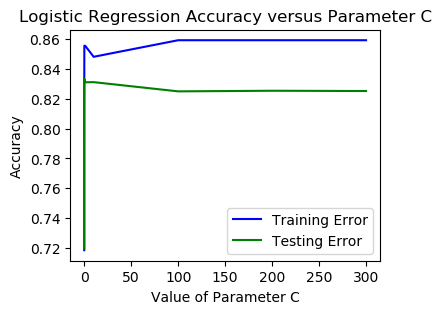

In [27]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

plt.rcdefaults()
plt.figure(figsize=(4,3))
trainAcc = plt.plot(c_param, tracc, '-b', label='Training Error')
testACC = plt.plot(c_param, tstacc, '-g', label='Testing Error')
plt.title("Logistic Regression Accuracy versus Parameter C")
plt.ylabel("Accuracy")
plt.xlabel("Value of Parameter C")
plt.legend(loc="best")
plt.show(block=False)

In [28]:
model = input("Enter Best Model: ")
best = cont[int(model)]
lr_ct = pd.crosstab(best[1], best[0], margins=True)
lr_ct.columns = ["-'ve HD", "+'ve HD", "Total"]
lr_ct.index = ["-'ve HD", "+'ve HD", "Total"]
print()
print("Logistic Regression")
print(lr_ct)
print()

Enter Best Model: 2

Logistic Regression
         -'ve HD  +'ve HD  Total
-'ve HD    48163     9769  57932
+'ve HD     6741    34386  41127
Total      54904    44155  99059



In [29]:
Sens = lr_ct.iloc[1][1]/lr_ct.iloc[2][1]
Spec = lr_ct.iloc[0][0]/lr_ct.iloc[2][0]
PPV = lr_ct.iloc[1][1]/lr_ct.iloc[1][2]
NPV = lr_ct.iloc[0][0]/lr_ct.iloc[0][2]
ACC = (lr_ct.iloc[0][0] + lr_ct.iloc[1][1]) / lr_ct.iloc[2][2]
print("Logistic Regression: Sensitivity: %.2f Specificity: %.2f PPV: %.2f NPV: %.2f Accuracy: %.2f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

Logistic Regression: Sensitivity: 0.78 Specificity: 0.88 PPV: 0.84 NPV: 0.83 Accuracy: 0.83


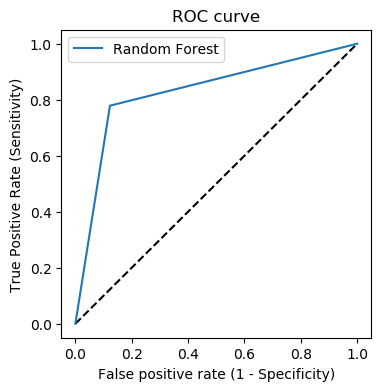

AUC =  0.8279893565120936


In [30]:
lr_fpr, lr_tpr, lr_thresholds = roc_curve(best[0], best[1], pos_label=2)
roc_auc = auc(lr_fpr, lr_tpr)
plt.rcdefaults()
plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot( lr_fpr, lr_tpr, label='Random Forest')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)